# Computer Vision Projects

## (1) Mnist Example

## Installations

### Dependencies

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import cv2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Configurations

In [2]:
# Declerating the configuration params
AUTOTUNE = tf.data.experimental.AUTOTUNE


tb_log_dir = './logs'


batch_size=256
img_resize = (32, 32)
img_size = img_resize + (3,) # we will cast the channels to use state of art models

## Data

### Downloading the dataset
- [MNIST DATASET](http://yann.lecun.com/exdb/mnist/)

In [58]:
#split_strs = ['train[:80%]', 'train[80%:90%]', 'train[90%:]']
dataset, info = tfds.load('mnist', as_supervised=True,shuffle_files=True, with_info=True)

In [59]:
info

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='/root/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)

In [60]:
dataset

{'test': <PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 'train': <PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>}

In [61]:
test_ds, train_ds = dataset["test"], dataset["train"]

In [62]:
test_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [63]:
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [64]:
class_names = info.features["label"].names
class_names

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

### Visualization of the dataset

```python
# when using load from dir method, it will ecnode the labels
# You can use following code
train_coded_ids = class_names

def decode_the_label(encoding_index, encoding=train_coded_ids):
  class_id = int( encoding[encoding_index] )
  class_name = classes[class_id]
  return class_name
```

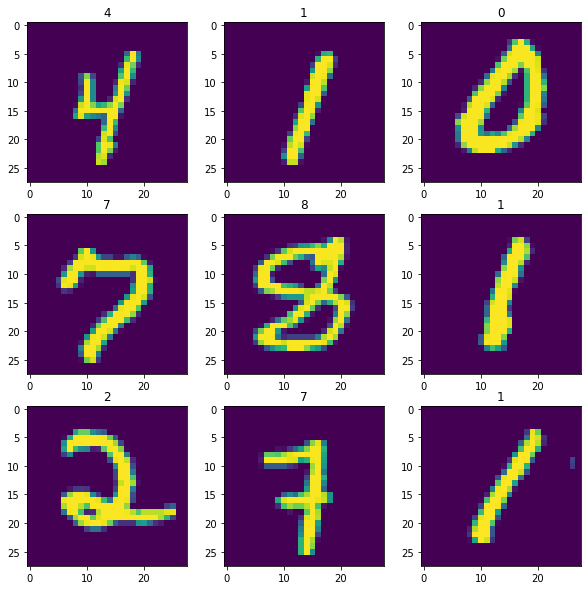

In [65]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, (image, id) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image) 
    plt.title(str(int(id)))

### Splitting the dataset

In [66]:
def split_dataset(dataset, train_split=0.6, val_split=0.2, shuffle_buffer_size=1024):
    # Shuffling for randomless
    dataset = dataset.shuffle(buffer_size=shuffle_buffer_size)
    
    # extracting the dataset info
    dataset_size = tf.data.experimental.cardinality(dataset).numpy()
    train_size = int(dataset_size * train_split)
    val_size = int(dataset_size * val_split)
    test_size = dataset_size - train_size - val_size


    # Dataset splits
    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size).take(val_size)
    test_dataset = dataset.skip(train_size + val_size)


    return train_dataset, val_dataset, test_dataset

def split_train_val(dataset, train_split=0.8, val_split=0.2, shuffle_buffer_size=1024):
    # Shuffling for randomless
    dataset = dataset.shuffle(buffer_size=shuffle_buffer_size)
    
    # extracting the dataset info
    dataset_size = tf.data.experimental.cardinality(dataset).numpy()
    train_size = int(dataset_size * train_split)
    val_size = int(dataset_size * val_split)

    # Dataset splits
    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size).take(val_size)

    return train_dataset, val_dataset

In [67]:
train_ds, val_ds = split_train_val(train_ds)

### preprocessing

In [68]:
def process_image(image, label):
    # Cast the image to tf.float32
    image = tf.cast(image, tf.float32)
    
    # 1 channel to 3 channel
    rgb_image = tf.repeat(image, 3, axis=-1)

    # Resize the image to img_resize
    image = tf.image.resize(rgb_image, img_resize)
    
    # Normalize the image
    image /= 255.0
    
    # Return the processed image and label
    return image, label


In [69]:
train_ds = train_ds.map(process_image)
val_ds = val_ds.map(process_image)
test_ds = test_ds.map(process_image)

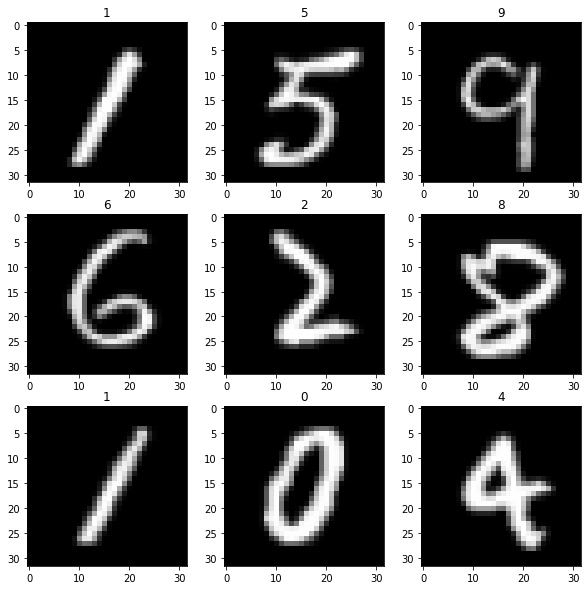

In [70]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, (image, id) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image, cmap="binary") 
    plt.title(str(int(id)))

### Data Augmentation

#### Util Function 

In [71]:
from albumentations import (
    Compose, RandomBrightness, JpegCompression, HueSaturationValue, RandomContrast, HorizontalFlip,
    Rotate
)


# Instantiate augments
# we can apply as many augments we want and adjust the values accordingly
# here I have chosen the augments and their arguments at random
transforms = Compose([
            Rotate(limit=30),
            #RandomBrightness(limit=0.1),
            # JpegCompression(quality_lower=85, quality_upper=100, p=0.5),
            # HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
            # RandomContrast(limit=0.2, p=0.5),
            #HorizontalFlip(),
        ])


def aug_fn(image, img_size):
    data = {"image":image}
    aug_data = transforms(**data)
    aug_img = aug_data["image"]
    #aug_img = tf.cast(aug_img/255.0, tf.float32)
    aug_img = tf.image.resize(aug_img, size=img_size)
    return aug_img


def image_augment(image, label, img_size):
    aug_img = tf.numpy_function(func=aug_fn, inp=[image, img_size], Tout=tf.float32)
    return aug_img, label


#### visualizating the data augmentation

```python
from tensorflow.keras import layers

data_augmentation_layer_before_process = tf.keras.Sequential([
  #layers.RandomFlip("horizontal_and_vertical"), # it can confuse left and rigt
  layers.RandomCrop(height=256, width=256),
  layers.RandomRotation(0.01),
  layers.RandomZoom(0.2),
])

data_augmentation_layer = tf.keras.Sequential([
  #layers.RandomFlip("horizontal_and_vertical"), # it can confuse left and rigt
  layers.RandomCrop(height=30, width=30),
  layers.RandomRotation(0.01),
  layers.RandomZoom(0.2),
])
```

In [72]:
class_names # info.features["label"].names

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

##### util functions

In [73]:
def get_a_sample(train_ds, class_names):
  
  sample_data = {}
  is_collected = {class_name : False for class_name in class_names}
  
  for image, class_name in train_ds.take(len(train_ds)):
    
     # type casting
    class_name = int(class_name)

    # collecting a sample per label
    if class_name not in sample_data.keys():
      sample_data[class_name] = image
      is_collected[class_name] = True 
    
    # check whether collected all classes
    if all(is_collected.values()):
      break

  return sample_data

def augment_per_class(sample_data, ordered_class_names, aug_size = 8, figsize=(30,30)):
  rs, cs = len(sample_data), aug_size+1
  plt.figure(figsize=figsize)

  for row_id, class_name in enumerate(ordered_class_names):
    # extracting the image
    image = sample_data[int(class_name)]

    # plotting the original image in the first axis
    first_col_on_cur_row = row_id*cs + 1
    plt.subplot(rs, cs , first_col_on_cur_row)
    plt.imshow(image, cmap="binary") # astype("uint8"),
    plt.title(f"Original Image of {class_name} class")
    plt.axis("off")


    for col_id in range(1, cs):
        
        # augmenting same image 
        data = {"image":np.array(image)}
        aug_img = transforms(**data)["image"]

        # plotting 
        cur_col = first_col_on_cur_row + col_id 
        plt.subplot(rs, cs ,  cur_col)
        plt.imshow(aug_img, cmap="binary")
        plt.axis("off")
        

In [112]:
import os 
import cv2

def save_sample_data(sample_data, path="sample_images"):
  
  if not os.path.exists(path): os.mkdir(path)

  for name, image in  sample_data.items():
    file_name = os.path.join(path, f"{str(name)}.png")
    image = np.array(image) * 255

    cv2.imwrite(file_name, image)  
  

#### Implementation

In [74]:
sample_data = get_a_sample(train_ds, class_names)

In [75]:
sample_data.keys()

dict_keys([5, 7, 8, 2, 0, 4, 3, 6, 1, 9])

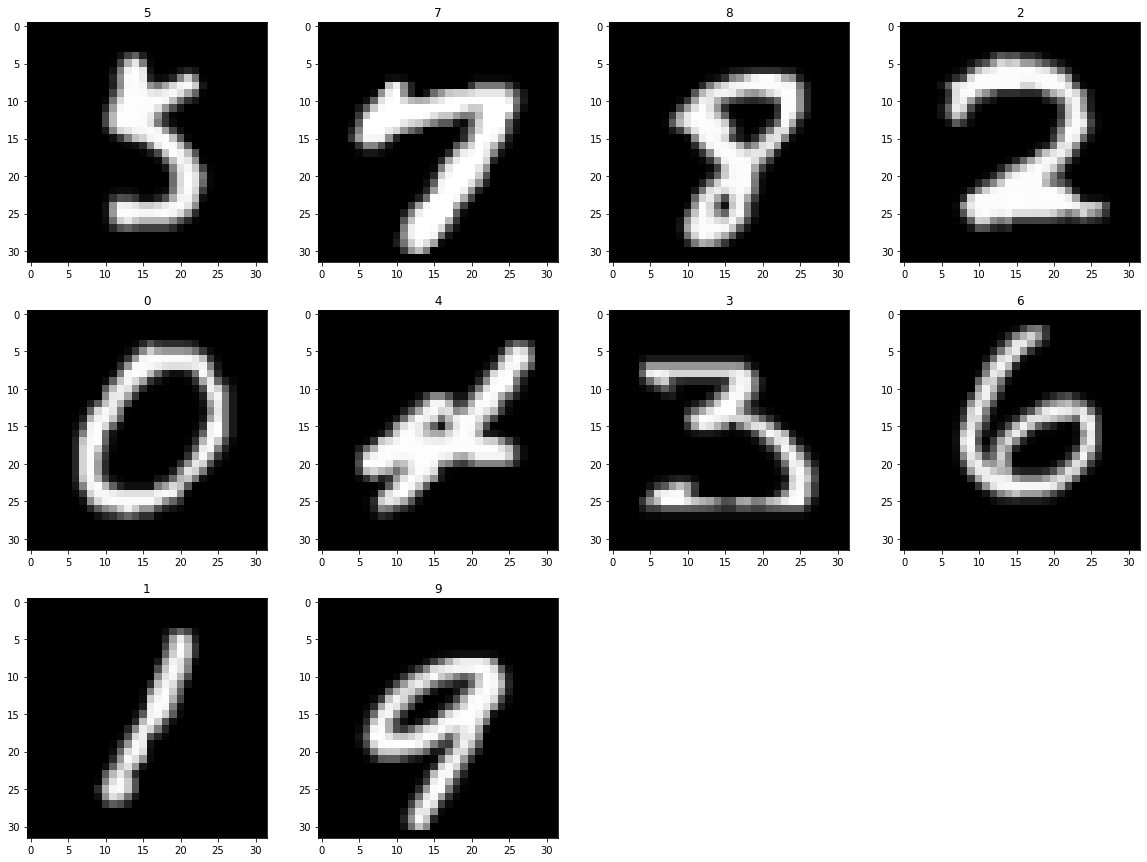

In [76]:
rs, cs = len(sample_data)//4+1, 4
plt.figure(figsize=(cs*5, rs*5))
for i, (name, image) in enumerate(sample_data.items()):
  plt.subplot(rs, cs, i+1)
  plt.imshow(image)
  plt.title(str(name))

In [120]:
save_sample_imgs = "sample_images"
save_sample_data(sample_data, save_sample_imgs)

In [121]:
os.system(f"zip {save_sample_imgs}.zip {save_sample_imgs}")

0

In [124]:
from google.colab import files
files.download(f"{save_sample_imgs}.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [77]:
class_names

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

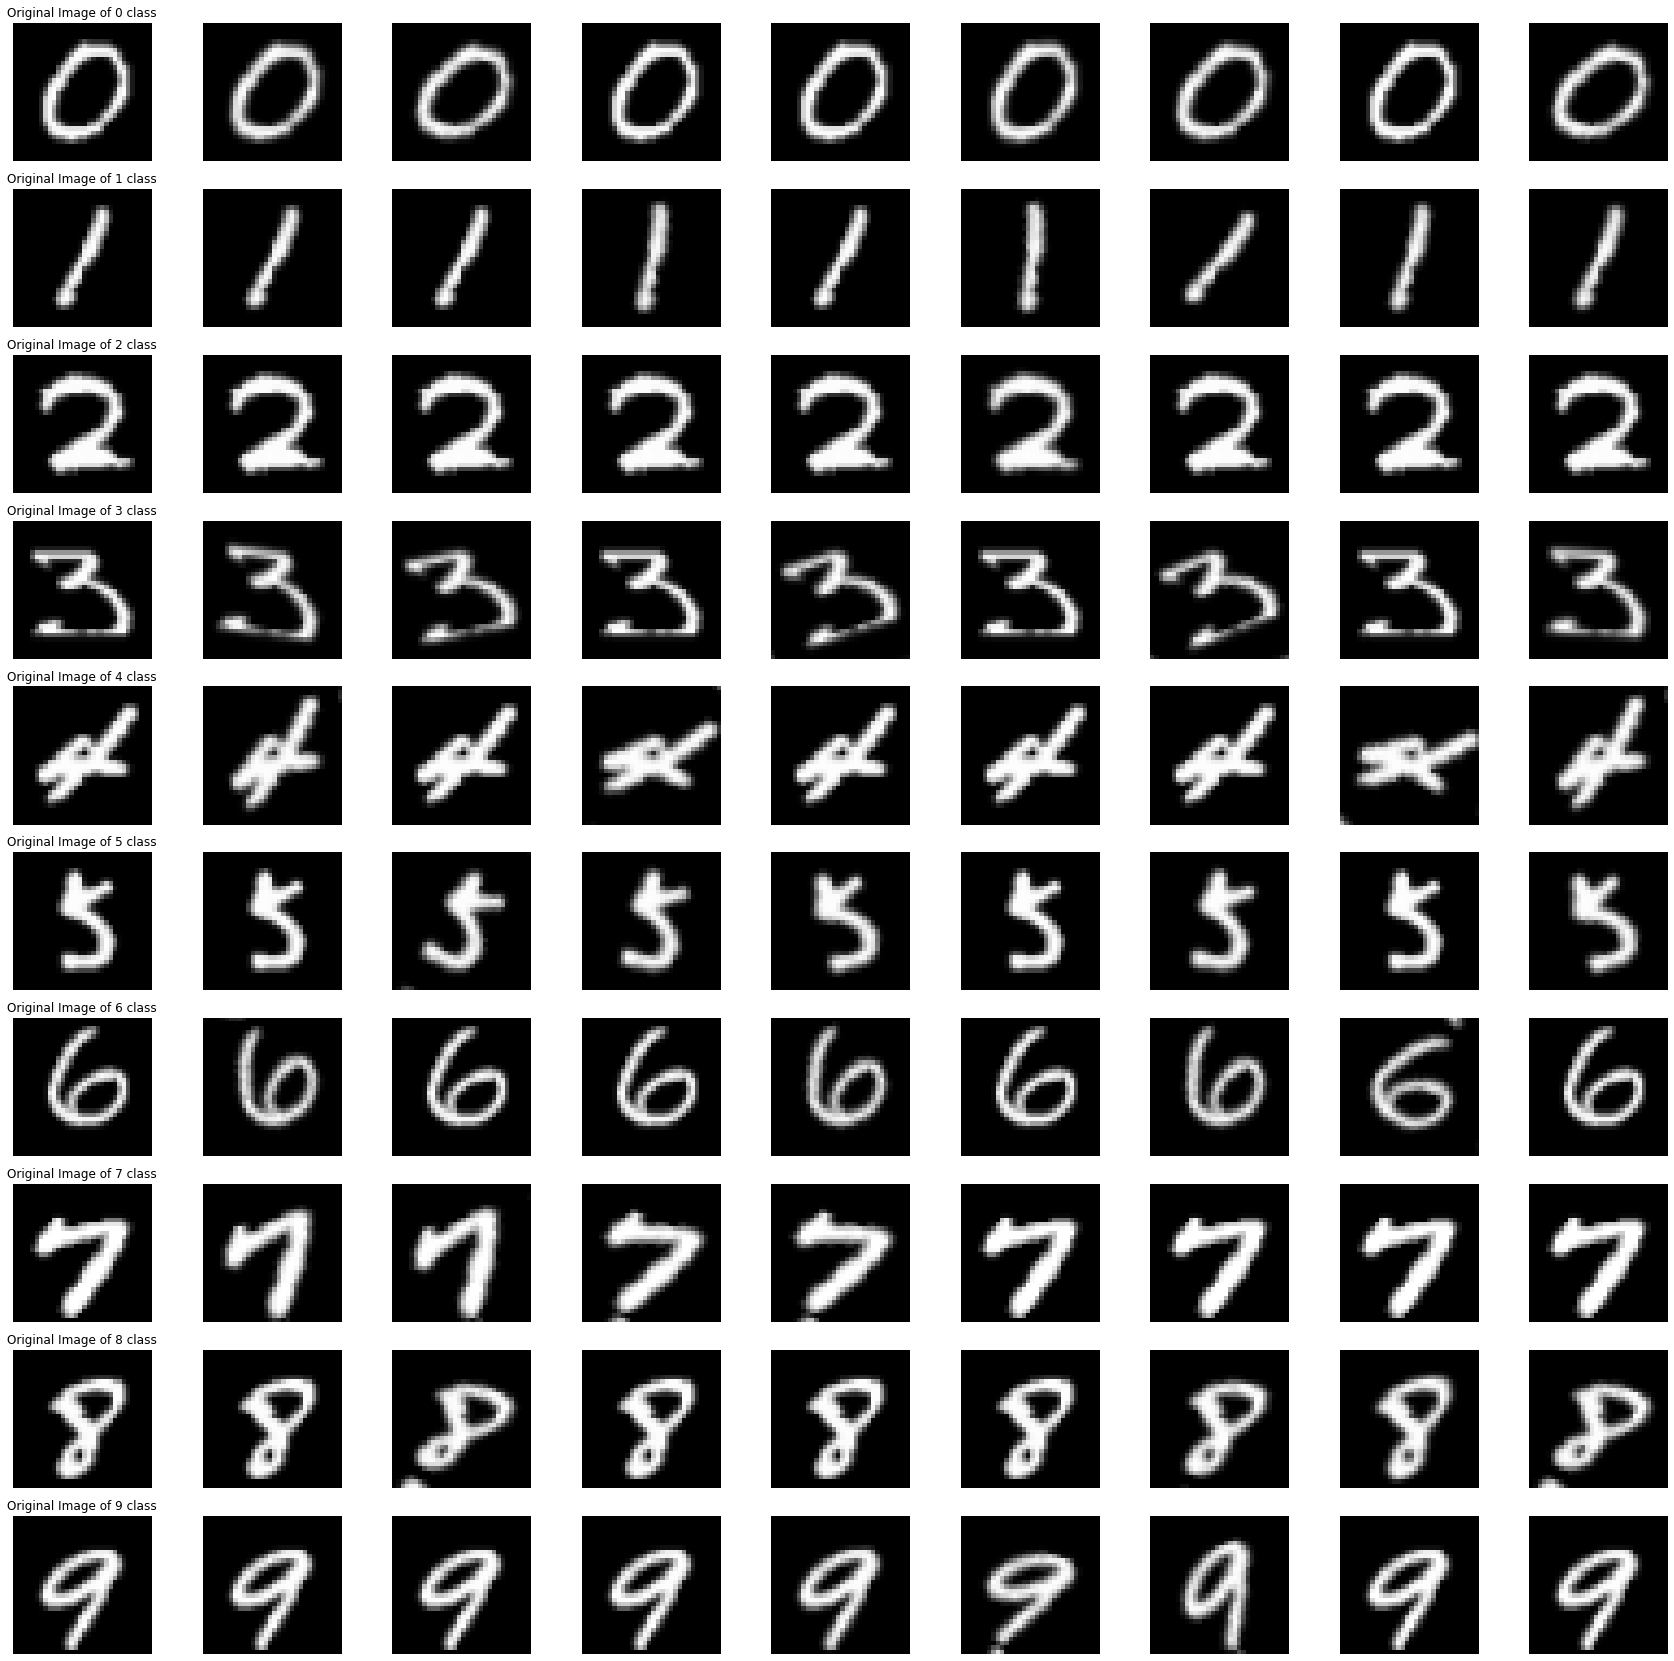

In [78]:
augment_per_class(sample_data, class_names)

#### Implementing the augmentation

In [79]:
from functools import partial
train_ds = train_ds.map(partial(image_augment, img_size=img_resize),num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

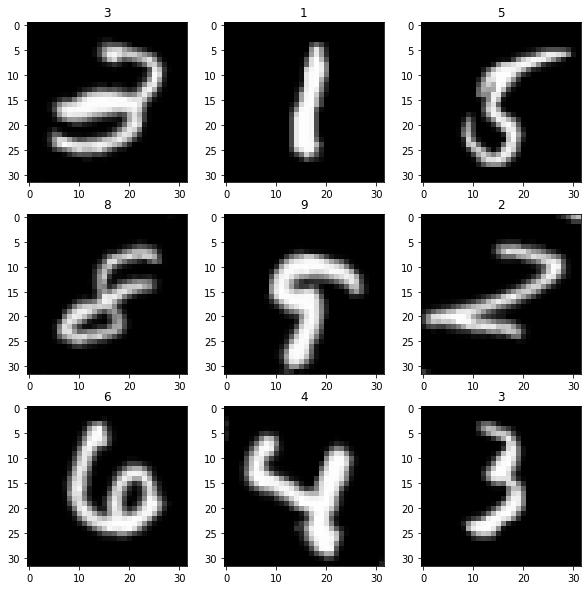

In [80]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, (image, id) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image) 
    plt.title(str(int(id)))

### Dataset Optimization Config

In [81]:
train_ds = train_ds.batch(batch_size).prefetch(AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(AUTOTUNE)
test_ds = test_ds.batch(batch_size).prefetch(AUTOTUNE)

## Modelling

### Basic Modelling

#### Architecture

In [82]:
# Importing the required Keras modules containing model and layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
# Creating a Sequential Model and adding the layers

# input layer
input = Input(shape=img_size)

# 1. conv block
x = Conv2D(32, kernel_size=(3,3))(input)
x = MaxPooling2D(pool_size=(2, 2))(x)

# 2. conv block
x = Conv2D(64, kernel_size=(3,3))(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# fully connected layer
x = Flatten()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.2)(x)

# classifier Dense
output = Dense(len(class_names), activation="softmax")(x)


# Connecting the model
model = Model(input, output)

In [83]:
model.compile(optimizer='adam',  loss='sparse_categorical_crossentropy',  metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 2304)              0   

#### Callbacks

In [84]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, CSVLogger, LearningRateScheduler, ReduceLROnPlateau, LambdaCallback
import numpy as np

# Temporary save paths
checkpoint_path = "Temporary_Basic_ModelCheckpoint.h5"
tb_log_dir = "./logs"

In [85]:
callbacks = [
    TensorBoard(log_dir=tb_log_dir),
    ModelCheckpoint(filepath= checkpoint_path, save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1),
    EarlyStopping(monitor='val_loss', patience=2, verbose=1),
    CSVLogger(filename='basic_training.log'),
]

#### Training

In [86]:
history = model.fit(train_ds, validation_data = val_ds, callbacks=callbacks,  epochs=20) 

Epoch 1/20
188/188 [==============================] - ETA: 0s - loss: 0.3761 - accuracy: 0.8835
Epoch 1: val_loss improved from inf to 0.08456, saving model to Temporary_Basic_ModelCheckpoint.h5
188/188 [==============================] - 80s 366ms/step - loss: 0.3761 - accuracy: 0.8835 - val_loss: 0.0846 - val_accuracy: 0.9748
Epoch 2/20
188/188 [==============================] - ETA: 0s - loss: 0.1167 - accuracy: 0.9639
Epoch 2: val_loss improved from 0.08456 to 0.06041, saving model to Temporary_Basic_ModelCheckpoint.h5
188/188 [==============================] - 63s 335ms/step - loss: 0.1167 - accuracy: 0.9639 - val_loss: 0.0604 - val_accuracy: 0.9821
Epoch 3/20
188/188 [==============================] - ETA: 0s - loss: 0.0862 - accuracy: 0.9736
Epoch 3: val_loss improved from 0.06041 to 0.04491, saving model to Temporary_Basic_ModelCheckpoint.h5
188/188 [==============================] - 64s 342ms/step - loss: 0.0862 - accuracy: 0.9736 - val_loss: 0.0449 - val_accuracy: 0.9858
Epoch

#### Visualiting Training History

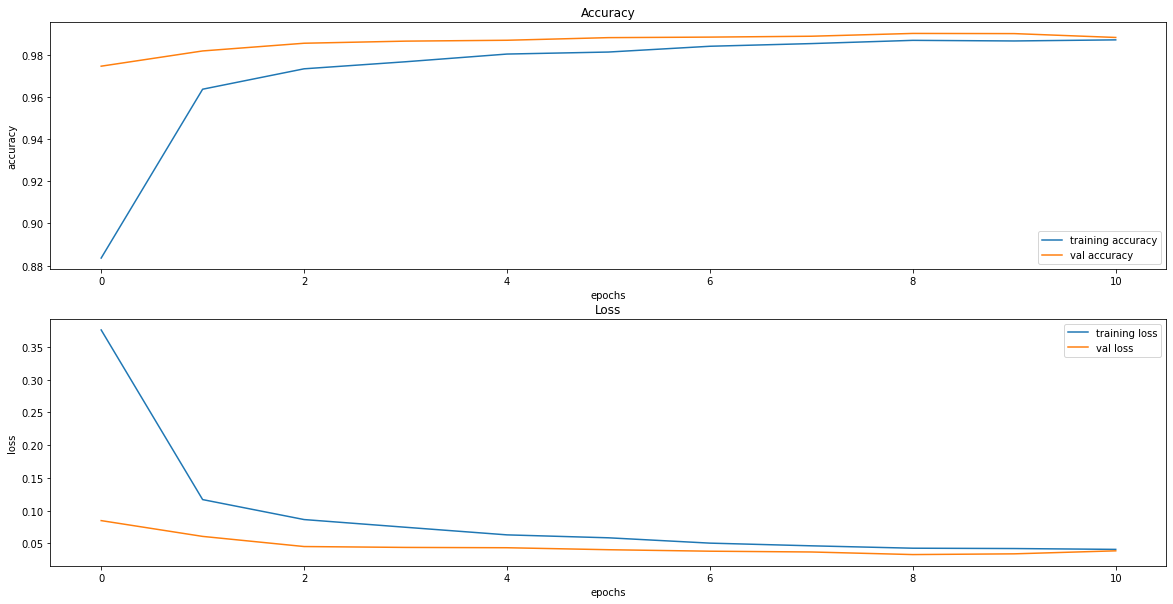

In [87]:
#Display of the accuracy and the loss values
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))

plt.subplot(2,1,1)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()


plt.subplot(2,1,2)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

#### Downloading the basic model

##### Save the best model

In [88]:
# Load the best weights
model.load_weights(checkpoint_path)

# best_model = tf.keras.models.load_model('saved_model/my_model') # best_model_save_path

In [90]:
model.evaluate(val_ds)

47/47 [==============================] - 1s 15ms/step - loss: 0.0327 - accuracy: 0.9905


[0.03269750252366066, 0.9904999732971191]

In [89]:
from datetime import datetime


now = datetime.now().strftime("%m-%d-%Y_%H:%M:%S")
best_model_save_path = f"Basic_{model.name}_{now}" 


model.save(best_model_save_path)

##### Select the model path

In [91]:
best_model_save_path

'Basic_model_1_03-06-2023_21:25:35'

##### Zip the model

In [92]:
dst, src = f"{best_model_save_path}.zip", best_model_save_path

In [93]:
import os
# Zipping the model to download
os.system(f"zip -r {dst} {src}")

0

##### Download the model

In [94]:
# Downloading the zipped model into the local
from google.colab import files
files.download(dst)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Transfer Learning

#### Base Model

In [ ]:
# Load a pre-trained model
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=img_size)

# Freeze the base model
base_model.trainable = False

#### Architectures

- Architectures
  - Classic Convolutional Neural Network (CNN) based models:
    - LeNet-5
    - AlexNet
    - ZFNet
    - VGGNet
    - ResNet
    - InceptionNet
    - Xception
  - Residual Network (ResNet) based models:
    - ResNet
    - ResNeXt
    - DenseNet
  - Attention-based models:
    - SE-Net
    - CBAM-Net
    - Non-local Neural Networks
  - Lightweight models:
    - MobileNet
    - ShuffleNet
    - EfficientNet
    - MnasNet
  - Object Detection models:
    - YOLO (You Only Look Once)
    - SSD (Single Shot MultiBox Detector)
    - Faster R-CNN
    - Mask R-CNN

Sequential Model
```python
# Add a custom head on top of the base model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(5, activation='softmax')
])


# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

```

Functional Model
```python
# Add a custom head on top of the base model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(5, activation='softmax')
])


# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

```

In [ ]:
# Add a custom head on top of the base model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])


# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#### Callbacks

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, CSVLogger, LearningRateScheduler, ReduceLROnPlateau, LambdaCallback
import numpy as np

def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.5
    epochs_drop = 5.0
    lrate = initial_lrate * np.power(drop, np.floor((1+epoch)/epochs_drop))
    return lrate

def print_current_lr(epoch, logs):
    print("Learning rate in epoch {} is {}".format(epoch, float(tf.keras.backend.get_value(model.optimizer.lr))))

# Temporary save paths
checkpoint_path = "TemporaryModel_ModelCheckpoint.h5"
tb_log_dir = "./logs"

In [ ]:
callbacks = [
    LearningRateScheduler(step_decay),
    TensorBoard(log_dir=tb_log_dir),
    ModelCheckpoint(filepath= checkpoint_path, save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1),
    EarlyStopping(monitor='val_loss', patience=6, verbose=1),
    CSVLogger(filename='training.log'),
    LambdaCallback(on_epoch_end=print_current_lr)
]

#### Training

In [ ]:
# Train the model
history = model.fit(train_ds, validation_data = val_ds, callbacks=callbacks, epochs=150) #callbacks=callbacks,

Epoch 1/150
188/188 [==============================] - ETA: 0s - loss: 1.1001 - accuracy: 0.6247
Epoch 1: val_loss improved from inf to 1.02402, saving model to TemporaryModel_ModelCheckpoint.h5
Learning rate in epoch 0 is 0.10000000149011612
188/188 [==============================] - 66s 349ms/step - loss: 1.1001 - accuracy: 0.6247 - val_loss: 1.0240 - val_accuracy: 0.6499 - lr: 0.1000
Epoch 2/150
188/188 [==============================] - ETA: 0s - loss: 1.0901 - accuracy: 0.6299
Epoch 2: val_loss did not improve from 1.02402
Learning rate in epoch 1 is 0.10000000149011612
188/188 [==============================] - 150s 799ms/step - loss: 1.0901 - accuracy: 0.6299 - val_loss: 1.0272 - val_accuracy: 0.6541 - lr: 0.1000
Epoch 3/150
188/188 [==============================] - ETA: 0s - loss: 1.0969 - accuracy: 0.6248
Epoch 3: val_loss improved from 1.02402 to 1.01511, saving model to TemporaryModel_ModelCheckpoint.h5
Learning rate in epoch 2 is 0.10000000149011612
188/188 [==============

#### Visualiting Training History

In [ ]:
#Display of the accuracy and the loss values
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))

plt.subplot(2,1,1)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()


plt.subplot(2,1,2)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

### Fine-Tuning

### Model Saving

#### Save the best model

In [ ]:
# Load the best weights
model.load_weights(checkpoint_path)

# best_model = tf.keras.models.load_model('saved_model/my_model') # best_model_save_path

In [ ]:
from datetime import datetime


now = datetime.now().strftime("%m-%d-%Y_%H:%M:%S")
best_model_save_path = f"{model.name}_{now}" 


model.save(best_model_save_path)

#### Downloading the models

##### Select the model path

In [ ]:
model_path = best_model_save_path
all_models = best_model_save_path #"/content/Models"
best_model_save_path

'best_model_02-09-2023_14:45:40'

##### Zip the model

###### Alternative Zipping -1 

```python
import os, shutil
zipped_dir = all_models
shutil.make_archive(zipped_dir, 'zip', ".")
```

###### Alternative Zipping - 2
```python
# Zipping via Bash code, if shutil didn't work
!zip -r "/content/model.zip" "/content/Model"

# Copy the file into google drive
!cp -rv '/content/file.zip' '/content/drive/MyDrive/Home'

# Download the model into your local
from google.colab import files
files.download('/content/file.zip')
```

In [ ]:
from google.colab import drive, files
import os

# Connecting the drive
drive.mount('/gdrive')

In [ ]:
dst, src = f"{best_model_save_path}.zip", best_model_save_path
dst_g_disk = "/content/drive/MyDrive/Home"

('best_model_02-09-2023_14:45:40.zip', 'best_model_02-09-2023_14:45:40')

In [ ]:
# Zipping the model to download
os.system(f"zip -r {dst} {src}")

0

In [ ]:
# Copying the zipped model into google drive
os.system(f"cp -rv {dst} {dst_g_disk}")

##### Download the zipped file into the local

In [ ]:
# Downloading the zipped model into the local
from google.colab import files
files.download(dst)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Deployment Web app

In [1]:
!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 43.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.7/140.7 KB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 KB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 KB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.2/56.2 KB 663.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 KB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 KB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 KB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 46.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 KB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 K

In [2]:
!unzip sample_images.zip

Archive:  sample_images.zip
   creating: sample_images/
  inflating: sample_images/0.png     
  inflating: sample_images/1.png     
  inflating: sample_images/2.png     
  inflating: sample_images/3.png     
  inflating: sample_images/4.png     
  inflating: sample_images/5.png     
  inflating: sample_images/6.png     
  inflating: sample_images/7.png     
  inflating: sample_images/8.png     
  inflating: sample_images/9.png     


In [3]:
!unzip BasicModel.zip

Archive:  BasicModel.zip
   creating: BasicModel/
   creating: BasicModel/assets/
  inflating: BasicModel/fingerprint.pb  
  inflating: BasicModel/keras_metadata.pb  
  inflating: BasicModel/saved_model.pb  
   creating: BasicModel/variables/
  inflating: BasicModel/variables/variables.data-00000-of-00001  
  inflating: BasicModel/variables/variables.index  


In [4]:
import gradio as gr
import tensorflow as tf
from glob import glob
import cv2
import os
import numpy as np

model_path = "BasicModel"
model = tf.keras.models.load_model(model_path)
labels = [str(i) for i in range(10)]

example_images = glob('sample_images/*.png')

In [5]:
labels 

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [6]:
example_images

['sample_images/6.png',
 'sample_images/4.png',
 'sample_images/5.png',
 'sample_images/0.png',
 'sample_images/3.png',
 'sample_images/8.png',
 'sample_images/7.png',
 'sample_images/9.png',
 'sample_images/2.png',
 'sample_images/1.png']

In [7]:
def process_image(image):
    # Convert into tensor
    image = tf.convert_to_tensor(image)

    # Cast the image to tf.float32
    image = tf.cast(image, tf.float32)
    
    # Resize the image to img_resize
    image = tf.image.resize(image, (32,32))
    
    # Normalize the image
    image /= 255.0
    
    # Return the processed image and label
    return image

def predict(image):

  # Pre-procesing the data
  images = process_image(image)

  # Batching
  batched_images = tf.expand_dims(images, axis=0)
  
  prediction = model.predict(batched_images).flatten()
  confidences = {labels[i]: np.round(float(prediction[i]), 3) for i in range(len(labels))}
  return confidences

In [8]:
demo = gr.Interface(fn=predict, 
             inputs=gr.Image(shape=(32, 32)),
             outputs=gr.Label(num_top_classes=len(labels)),
             examples=example_images)
             
demo.launch()

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>